In [1]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.1 MB/s 


In [2]:
import os
import glob
import pydicom

import PIL
import torch
import torchvision
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["axes.grid"] = False



In [3]:
# Mount the google drive. this is additional configuration needed if we use google colabs 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
seed = 42
num_classes = 2
batch_size = 10
train_img_size = 256 
origin_img_size = 1024
scale_factor = train_img_size / origin_img_size
np.random.seed(seed)
TRAIN_DIR = "stage_2_train_images"
TEST_DIR = "stage_2_test_images"
ROOT_DIR = "/content/drive/My Drive/Capstone_CV1_Group4/"
LABELS_FILE = "stage_2_train_labels.csv"
SUBMISSION_FILE = "stage_2_sample_submission.csv"
rcnn_losses = ["loss_objectness", "loss_box_reg", "loss_rpn_box_reg"]

In [8]:
train_imgs = os.listdir(os.path.join(ROOT_DIR, TRAIN_DIR))
test_imgs =  [patienId + ".dcm" for patienId in pd.read_csv(os.path.join(ROOT_DIR, SUBMISSION_FILE)).patientId]

Let's split our training dataset into training and validation sets. We leave one third of training samples for validation.

In [9]:
from sklearn.model_selection import train_test_split

train_imgs, valid_imgs = train_test_split(train_imgs, test_size=0.33, random_state=seed)

print(f"Number of training samples: {len(train_imgs)}")
print(f"Number of validation samples: {len(valid_imgs)}")

Number of training samples: 17878
Number of validation samples: 8806


**Data Preprocessing and Visualization**


Pneumonia bounding boxes coordinates are sored in stage_2_train_labels.csv file. There are a lot of lines with zero target value and NaN value in box columns. These lines represent images without bounding box.

In [10]:
train_label_df = pd.read_csv(os.path.join(ROOT_DIR, LABELS_FILE))
train_label_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


 

*   Model requires box coordinates in format X0, X1. So we need to rename x to X0 and y to Y0.
*   We also multiply bounding box coordinates with scale_factor since we will train our model on images of size 256 instead of their original size 1024.
*   R-CNN also require area of bounding box as input.

In [11]:
isna_count = len(train_label_df[train_label_df.Target == 0]) # number of images without bounding box

train_label_df = train_label_df[train_label_df.Target == 1]

train_label_df.rename(columns={"x": "X0", "y": "Y0"}, inplace=True)
train_label_df["X1"] = train_label_df["X0"] + train_label_df["width"]
train_label_df["Y1"] = train_label_df["Y0"] + train_label_df["height"]

train_label_df[["X0", "X1", "Y0", "Y1"]] = train_label_df[["X0", "X1", "Y0", "Y1"]] * scale_factor
train_label_df["area"] = train_label_df["width"] * scale_factor * train_label_df["height"] * scale_factor

train_label_df.drop(["width", "height"], axis=1, inplace=True)
train_label_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

,patientId,X0,Y0,Target,X1,Y1,area
4,00436515-870c-4b36-a041-de91049b9ab4,66.00,38.00,1,119.25,132.75,5045.4375
5,00436515-870c-4b36-a041-de91049b9ab4,140.50,38.00,1,204.50,151.25,7248.0000
8,00704310-78a8-4b38-8475-49f4573b2dbb,80.75,144.25,1,120.75,170.25,1040.0000
9,00704310-78a8-4b38-8475-49f4573b2dbb,173.75,143.75,1,214.25,178.00,1387.1250
14,00aecb01-a116-45a2-956c-08d2fa55433f,72.00,80.50,1,95.50,114.25,793.1250


Let´s check how many images have zero, one or more bounding boxes.

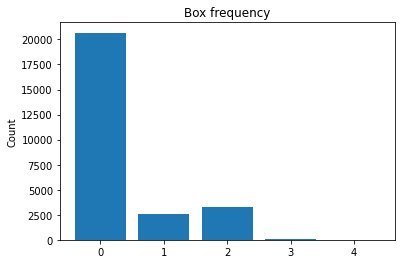

In [12]:
from collections import Counter

counter = Counter(train_label_df.patientId)

sample_batch = [sample[0] + ".dcm" for sample in counter.most_common(2)] # We will take two imgs with 4 boxes to display
counts = pd.Series(counter.values()).value_counts()
counts[0] = isna_count
plt.title("Box frequency")
plt.ylabel("Count")
plt.xticks(counts.index)
plt.bar(counts.index, counts)
plt.show()
del counter

In [13]:
counts.sort_values(ascending=False)

0    20672
2     3266
1     2614
3      119
4       13
dtype: int64

*   Most of images do not have any bounding box. 
*   There is also a handful of images with three and four bounding boxes.


**Previously we calculated bounding boxes area so we can now disply area distribution.**

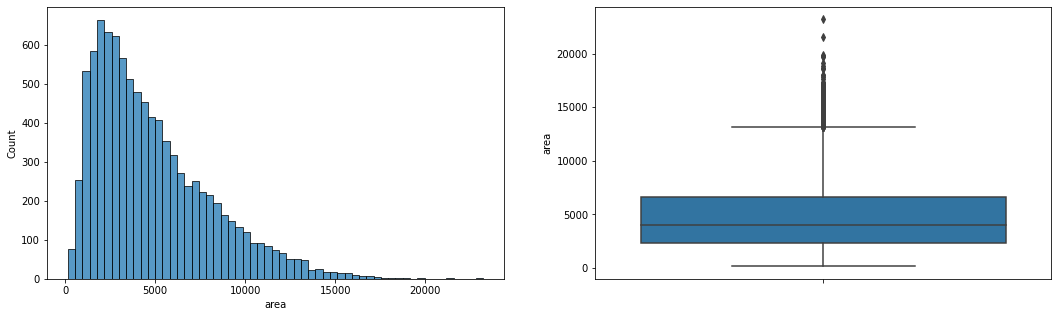

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5))
sns.histplot(data=train_label_df, x="area", ax=axs[0])
sns.boxplot(y=train_label_df["area"])
plt.show()

*   Most of boxes have area smaller than 7000. 
*   There are outliers with area greater than 15000. 

**Let's define helper functions to display samples batch along with boxes.**

In [15]:
from torchvision.utils import draw_bounding_boxes, make_grid


def find_boxes(img_name, label_df): 
    patient_id = img_name.split(".")[0]
    boxes = label_df[label_df.patientId == patient_id]
    boxes_coord = boxes[["X0", "Y0", "X1", "Y1"]].to_numpy()
    
    return boxes_coord, boxes.area.to_numpy()



In [16]:
def plot_samples(batch, n_rows=3, n_cols=5, box_color="red", titles=None, box_width=3, fig_size=(20,12)):
    assert len(batch) >= n_rows * n_cols, f"Not enough samples to display, required at least {n_rows * n_cols} samples"
    fig, axs = plt.subplots(n_rows, 1, figsize=fig_size)
    fig.tight_layout()
    imgs_with_boxes = []
    for sample in batch[:n_rows * n_cols]:
        scores = None
        if len(sample) == 2:
            image, boxes = sample
        else:
            image, boxes, scores = sample 
            scores = [f"Score: {score:.2f}" for score in scores]
            
        img = draw_bounding_boxes(image=image.permute(2, 0, 1), 
                                  boxes=boxes, 
                                  colors=box_color, 
                                  labels=scores,
                                  width=box_width)
        imgs_with_boxes.append(img)
        
    for i, ax in enumerate(axs): 
        if titles:
            ax.set_title(titles[i], fontsize=18)
        img_with_boxes = make_grid(imgs_with_boxes[i * n_cols: (i + 1) * n_cols]).numpy()       
        ax.imshow(np.transpose(img_with_boxes, (1, 2, 0)))
    plt.show()

In [17]:
def read_images(img_names, label_df, resize):
    batch = []
    for img_name in img_names:
        img_path = os.path.join(ROOT_DIR, TRAIN_DIR, img_name)
        img = PIL.Image.fromarray(pydicom.dcmread(img_path).pixel_array).convert("RGB")
        img = img.resize(resize)
        img = np.array(img)
       
        boxes, _ = find_boxes(img_name, label_df)

        img = torch.tensor(img, dtype=torch.uint8)
        boxes = torch.tensor(boxes, dtype=torch.int32)
        batch.append((img, boxes))
    return batch

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:215: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


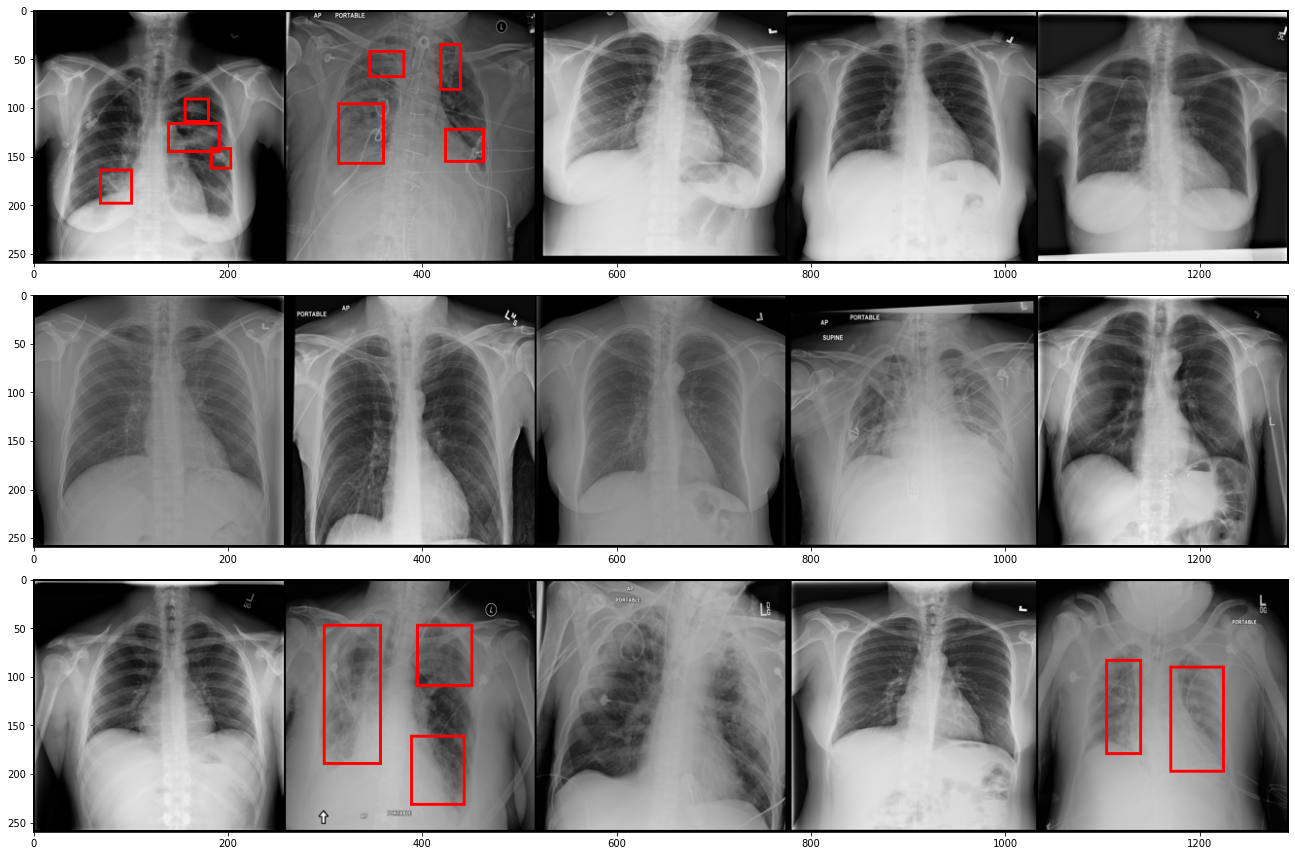

In [18]:
sample_batch = np.concatenate([sample_batch, np.random.choice(train_imgs, size=13)])
sample_batch = read_images(sample_batch, train_label_df, (train_img_size, train_img_size))
plot_samples(sample_batch)

Some bounding boxes covers small part of the lung while others covers most of the lung.

**Image augmentation**

We will use a nifty library for image augmentation imgaug. The library can perform geometric transformations along with bounding boxes, masks and key points. In addition we add some noice and blur to image.

In [19]:
import imgaug
from imgaug import augmenters as iaa 
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

class Augmentation:
    def __init__(self, 
                 x_translation=(-0.05, 0.05), 
                 rotate=(-5, 5),
                 scale=(0.9, 1.1),
                 noice=(0, 10),
                 blur=(0, 0.1)):
        
        self.transform = iaa.Sequential([            
            iaa.Affine(translate_percent={"x": x_translation}, scale=scale, rotate=rotate),
            iaa.AdditiveGaussianNoise(scale=noice),
            iaa.GaussianBlur(sigma=blur)])
    
    def __call__(self, image, boxes): 
        bbs = BoundingBoxesOnImage([BoundingBox(x1=box[0], y1=box[1], x2=box[2], y2=box[3]) 
                                    for box in boxes], shape=image.shape)
        
        image, bbs = self.transform(image=image, bounding_boxes=bbs)
        return image, bbs.to_xyxy_array()

    def worker_init_fn(self, worker_id):
        """Set unique seed for each worker."""
        imgaug.seed(np.random.get_state()[1][0] + worker_id)


In [20]:
from torchvision.transforms import PILToTensor, ConvertImageDtype

class PneumoniaDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms, img_names, train_img_size, labels=None):
        self.root = root
        self.transforms = transforms
        self.img_names = img_names
        self.resize = (train_img_size, train_img_size)       
        self.labels = labels
        
    def __getitem__(self, idx):
        """Load image, boxes and process them"""
        img_name = self.img_names[idx]
       
        img_path = os.path.join(self.root, self.img_names[idx])
        img = PIL.Image.fromarray(pydicom.dcmread(img_path).pixel_array).convert("RGB")
        img = img.resize(self.resize)
        img = np.array(img)
                 
        if self.labels is None:           
            return torch.tensor(img / 255.).permute(2, 0, 1).float() 
        
        boxes, area = find_boxes(img_name, self.labels)
        n_objects = len(boxes) 
        if self.transforms is not None:            
            img, boxes = self.transforms(img, boxes)
            
        img = torch.tensor(img / 255.).permute(2, 0, 1).float() 
               
        target = {}
        target["image_id"] = torch.tensor([idx])
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.ones(n_objects, dtype=torch.int64)
        target["area"] = torch.as_tensor(area, dtype=torch.float32)
        target["iscrowd"] = torch.zeros(n_objects, dtype=torch.int32)
        return img, target
        
    def __len__(self):
        return len(self.img_names)
    
    def collate_fn(self, batch):
        return tuple(zip(*batch))    

In [21]:
from torch.utils.data import DataLoader

augmentation = Augmentation()
train_ds = PneumoniaDataset(os.path.join(ROOT_DIR, TRAIN_DIR), augmentation, train_imgs, train_img_size, train_label_df)
valid_ds = PneumoniaDataset(os.path.join(ROOT_DIR, TRAIN_DIR), None, valid_imgs, train_img_size, train_label_df)
test_ds = PneumoniaDataset(os.path.join(ROOT_DIR, TEST_DIR), None, test_imgs, train_img_size)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=train_ds.collate_fn,  
                          worker_init_fn=augmentation.worker_init_fn)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=valid_ds.collate_fn) 
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2) 

We have image augmentation pipeline, we can display some augmented images and compare them with originals.

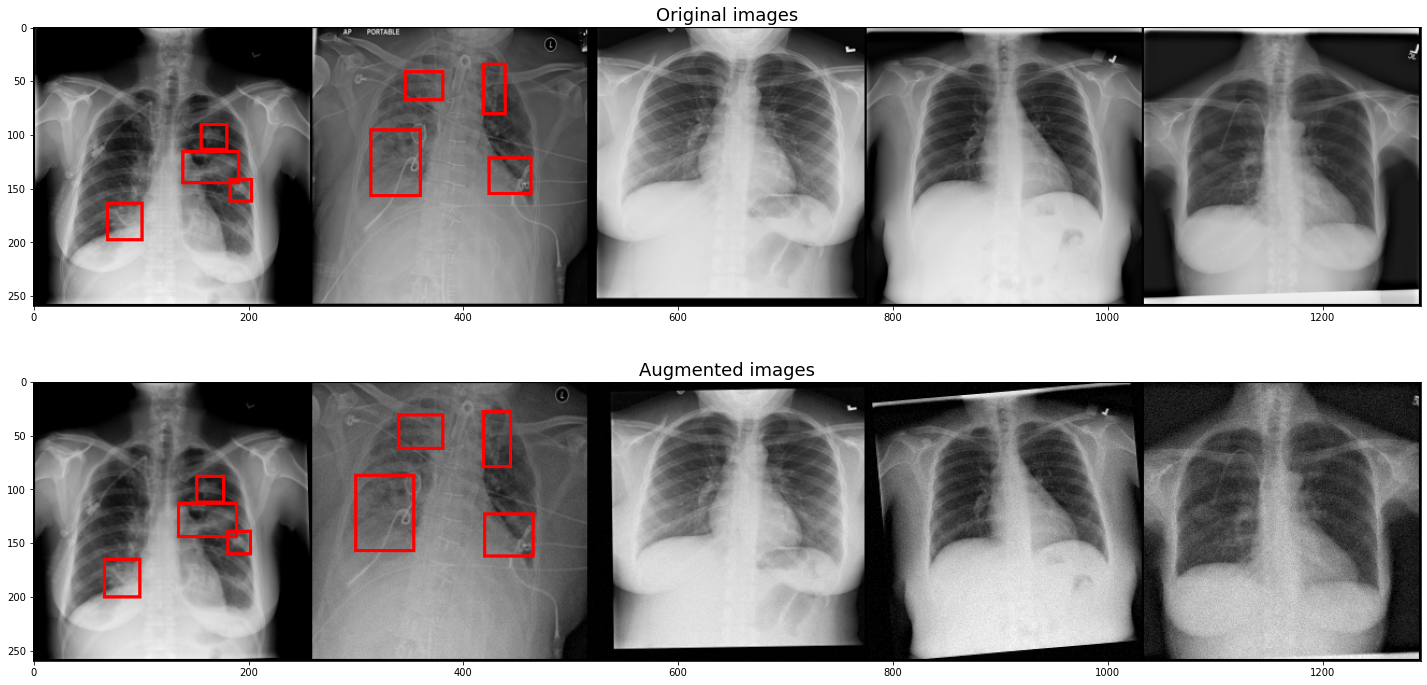

In [22]:
def process_batch(idx, sample):
    img, boxes = sample
            
    augmentation = Augmentation()
    augmentation.worker_init_fn(idx)
    img, boxes = augmentation(img.numpy(), boxes.numpy())
    img = torch.tensor(img, dtype=torch.uint8)
    boxes = torch.tensor(boxes, dtype=torch.float32)
    return img, boxes


augmented_batch = sample_batch[:5] + [process_batch(i, sample) for i, sample in enumerate(sample_batch[:5])] 
plot_samples(augmented_batch, titles=["Original images", "Augmented images"], fig_size=(20, 10), n_rows=2)
del sample_batch, augmented_batch


**Model**

We will finetune a model trained on COCO dataset. 
To do the same we have to replace model classifier with a new one adapted to our task. Our model will exploit Resnet50 as backbone. We incorporate our model into PyTorch lightning module. This way we can easily train and validate our model.

In [23]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 798 kB 4.6 MB/s 
     |████████████████████████████████| 529 kB 61.3 MB/s 
     |████████████████████████████████| 87 kB 8.4 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115940 sha256=601d212c5129113a5fd55d8e38d245d4616f39d016e3f96320c6dc4179f482a6
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [24]:
import pytorch_lightning as pl
from torchvision.ops import nms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


class LitRCNN(pl.LightningModule):    
    def __init__(self, num_classes):
        super().__init__()

        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
               
        self.model = model
        
    def forward(self, x):
        self.model.eval()
        
        outputs =  self.model(x)
        
        preds = []
        for output in outputs:       
            boxes = output["boxes"]
            scores = output["scores"]
            idx = nms(boxes,scores, 0.05)
            preds.append({"boxes": boxes[idx].cpu().detach().numpy(), "scores": scores[idx].cpu().detach().numpy()})
        
        return preds
        
    def training_step(self, batch, batch_idx):   
        images, targets = batch   
               
        losses = self.model(images, targets)  
      
        loss = sum(loss for loss in losses.values())        
        self.log_losses(loss, losses)   
        
        return loss
    
    def validation_step(self, batch, batch_idx):     
        self.model.train()
        
        images, targets = batch 
        losses = self.model(images, targets)
      
        loss = sum(loss for loss in losses.values())   
        self.log_losses(loss, losses, mode="val")
        
    def predict_step(self, batch, batch_idx):   
        return self.forward(batch)    
       
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(),  lr=0.005, momentum=0.9, weight_decay=0.0005)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.3)
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,  
                "interval": "epoch",
                "frequency": 1}}
    
    def log_losses(self, loss, losses, mode="train"): 
        self.log_dict({f"{mode}_loss": loss,                   
                       f"{mode}_loss_box_reg": losses['loss_box_reg'],
                       f"{mode}_loss_objectness": losses['loss_objectness'],
                       f"{mode}_loss_rpn_box_reg": losses['loss_rpn_box_reg']}, on_step=False, on_epoch=True, batch_size=batch_size)

model = LitRCNN(num_classes)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Lets define some callbacks for logging and model checkpoints.

In [25]:
from pytorch_lightning import Callback
from pytorch_lightning.callbacks import ModelCheckpoint


class MetricsCallback(Callback):
    """PyTorch Lightning metric callback."""

    def __init__(self, metrics):
        super().__init__()
        self.metrics = metrics      
        self.training = {}
        self.validations = {}
        
    def on_train_epoch_end(self, trainer, pl_module):
        self.training[trainer.current_epoch] = {metric: trainer.callback_metrics["train_" + metric] for metric in self.metrics}

    def on_validation_end(self, trainer, pl_module):        
        self.validations[trainer.current_epoch] = {metric: trainer.callback_metrics["val_" + metric] for metric in self.metrics}
        

checkpoint_callback = ModelCheckpoint(dirpath='checkpoints',
                                      filename='{epoch}-{val_loss:.4f}',
                                      every_n_epochs=1,
                                      monitor='val_loss',
                                      save_top_k=1,
                                      mode='min')

callbacks = [MetricsCallback(["loss"] + rcnn_losses), checkpoint_callback]


**Model Training**

In [ ]:
device = "gpu" if torch.cuda.is_available() else "cpu"
trainer = pl.Trainer(accelerator=device, max_epochs=6, callbacks=callbacks) 
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41.3 M
-------------------------------------
41.1 M    Trainable params
222 K     Non-trainable params
41.3 M    Total params
165.197   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
model = LitRCNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path, num_classes=num_classes)
print(trainer.checkpoint_callback.best_model_path)

**Model Evaluation**

Let's check some predictions on validation set

In [ ]:
sample_batch_idx = np.random.choice(len(valid_imgs), size=5)
sample_batch = read_images(np.array(valid_ds.img_names)[sample_batch_idx], train_label_df, (train_img_size, train_img_size))

preds = model([valid_ds[i][0] for i in sample_batch_idx])
for i, pred in enumerate(preds):
    sample_batch.append((sample_batch[i][0], 
                         torch.tensor(pred["boxes"], dtype=torch.int32),
                         pred["scores"]))
    
plot_samples(sample_batch, titles=["Validation", "Predictions"], fig_size=(20, 10), n_rows=2)

In [ ]:
sns.set_style("whitegrid")
training = pd.DataFrame.from_dict(callbacks[0].training, orient="index").applymap(lambda x: x.cpu().numpy())
validations = pd.DataFrame.from_dict(callbacks[0].validations, orient="index").applymap(lambda x: x.cpu().numpy())
fig, axs = plt.subplots(2, 2, figsize=(16, 8))

for ax, metric in zip(axs.flat, callbacks[0].metrics):    
    ax.set_title(metric)
    
    g = sns.lineplot(data=training, x=training.index, y=metric, ax=ax)
    g = sns.lineplot(data=validations, x=validations.index, y=metric, ax=ax)
    g.set(xlabel="Epoch", ylabel=None)
    g.set_xticks(training.index)
    ax.legend(labels=["Training","Validation"])
  
fig.tight_layout()
plt.show()

In [ ]:
history = trainer.validate(model, dataloaders=valid_loader, verbose=False)
pd.DataFrame(history, index=["Validation"]).T

**Submission**

In [ ]:
preds = trainer.predict(model, test_loader)

outputs = []
for batch_pred in preds:
    for sample_pred in batch_pred:
        scores, boxes = sample_pred["scores"], sample_pred["boxes"]
        if len(scores) == 0:
            outputs.append(np.nan)
        else:
            label = ""
            boxes = boxes / scale_factor
            for score, box in zip(scores, boxes):            
                label += f"{score:.2f} {box[0]:.1f} {box[1]:.1f} {(box[2]-box[0]):.1f} {(box[3]-box[1]):.1f} "
            outputs.append(label.strip())
    
submission = pd.read_csv(os.path.join(ROOT_DIR, SUBMISSION_FILE))
submission.PredictionString = outputs
submission.to_csv("submission.csv", header=True, index=False)
submission